In [16]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
# Set path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [4]:
# Import our modules
from src.models.multibranch import MultiBranchModel
from src.models.earlystop import EarlyStopping
from src.models.trainer import train_epoch, validate
from src.data.dataset import load_large_dataset
from src.data.dataset import CustomTensorDataset

In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Load datasets
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
train_data_dict = load_large_dataset(os.path.join(project_root, 'data', 'processed', 'train'), name="train_dataset")
val_data_dict = load_large_dataset(os.path.join(project_root, 'data', 'processed', 'val'), name="val_dataset")


Loading train_dataset...
Loading corrected tensor...


c:\Users\Francisco\Desktop\Diversa\projects\EPN\desarrollo\volcanesML\src\data\dataset.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  corrected_tensor = torch.load(os

Corrected tensor loaded with 5619 samples.
Loading edge tensor...


c:\Users\Francisco\Desktop\Diversa\projects\EPN\desarrollo\volcanesML\src\data\dataset.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  edge_tensor = torch.load(os.path

Edge tensor loaded with 5619 samples.
Loading threshold tensors...


c:\Users\Francisco\Desktop\Diversa\projects\EPN\desarrollo\volcanesML\src\data\dataset.py:139: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  threshold_tensors[level] = torch

Threshold tensor 'high' loaded with 5619 samples.
Threshold tensor 'low' loaded with 5619 samples.
Threshold tensor 'medium' loaded with 5619 samples.
Threshold tensor 'very_high' loaded with 5619 samples.
Loading labels and metadata...
Labels loaded with 5619 samples.
train_dataset loaded successfully!

Loading val_dataset...
Loading corrected tensor...


c:\Users\Francisco\Desktop\Diversa\projects\EPN\desarrollo\volcanesML\src\data\dataset.py:144: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  metadata = torch.load(os.path.jo

Corrected tensor loaded with 1405 samples.
Loading edge tensor...
Edge tensor loaded with 1405 samples.
Loading threshold tensors...
Threshold tensor 'high' loaded with 1405 samples.
Threshold tensor 'low' loaded with 1405 samples.
Threshold tensor 'medium' loaded with 1405 samples.
Threshold tensor 'very_high' loaded with 1405 samples.
Loading labels and metadata...
Labels loaded with 1405 samples.
val_dataset loaded successfully!


In [7]:
# Wrap in CustomTensorDataset
train_data = CustomTensorDataset(train_data_dict)
val_data = CustomTensorDataset(val_data_dict)

In [8]:
# Now create DataLoaders with the wrapped dataset objects
batch_size = 250
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

In [9]:
# Verify dataset sizes
print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")

# Verify data loading with updated dimensions
print("\nVerifying data loading...")
for batch in train_loader:
    print("\nBatch shapes:")
    print(f"Corrected: {batch['corrected'].shape}")       # Should be [batch_size, 1, 480, 640]
    print(f"Edge: {batch['edge'].shape}")                 # Should be [batch_size, 1, 480, 640]
    print(f"Thresholds: {batch['thresholds'].shape}")     # Should be [batch_size, 4, 480, 640]
    print(f"Labels: {batch['label'].shape}")              # Should be [batch_size]
    break

Training samples: 5619
Validation samples: 1405

Verifying data loading...

Batch shapes:
Corrected: torch.Size([250, 1, 480, 640])
Edge: torch.Size([250, 1, 480, 640])
Thresholds: torch.Size([250, 4, 480, 640])
Labels: torch.Size([250])


In [10]:
# Verify tensor types
print("\nVerifying tensor types...")
for batch in train_loader:
    print("\nBatch dtypes:")
    print(f"Corrected: {batch['corrected'].dtype}")
    print(f"Edge: {batch['edge'].dtype}")
    print(f"Thresholds: {batch['thresholds'].dtype}")
    print(f"Labels: {batch['label'].dtype}")
    break


Verifying tensor types...

Batch dtypes:
Corrected: torch.float32
Edge: torch.float32
Thresholds: torch.uint8
Labels: torch.int64


In [11]:
# Training setup
n_classes = 3
model = MultiBranchModel(n_classes, dropout_rate=0.6).to(device)

# Add L2 regularization (weight decay)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Add learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True,  min_lr=1e-6)

# Early stopping
early_stopping = EarlyStopping(patience=7, min_delta=1e-4)

Expected input dimensions:
Corrected & Edge branches: [batch_size, 1, 480, 640]
Threshold branch: [batch_size, 4, 480, 640]


c:\Users\Francisco\Desktop\Diversa\projects\EPN\desarrollo\volcanesML\volcanesML\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [12]:
# Training loop
print("\nStarting training...")
train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0.0
n_epochs = 25

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")
    
    # Train and validate
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Early stopping
    early_stopping(val_loss)
    
    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Print statistics
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss
        }, os.path.join(project_root, 'data', 'processed', 'best_model.pt'))
    
    # Check early stopping
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

print("\nTraining complete!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")


Starting training...

Epoch 1/25


Validating: 100%|██████████| 6/6 [00:12<00:00,  2.10s/it]


Train Loss: 0.9323, Train Acc: 49.67%
Val Loss: 0.7543, Val Acc: 64.98%
Learning Rate: 0.001000

Epoch 2/25


Validating: 100%|██████████| 6/6 [00:12<00:00,  2.09s/it]


Train Loss: 0.7552, Train Acc: 56.22%
Val Loss: 0.6724, Val Acc: 68.33%
Learning Rate: 0.001000

Epoch 3/25


Validating: 100%|██████████| 6/6 [00:12<00:00,  2.17s/it]


Train Loss: 0.6951, Train Acc: 62.80%
Val Loss: 0.6347, Val Acc: 68.61%
Learning Rate: 0.001000

Epoch 4/25


Validating: 100%|██████████| 6/6 [00:12<00:00,  2.10s/it]


Train Loss: 0.6521, Train Acc: 67.47%
Val Loss: 0.5922, Val Acc: 72.67%
Learning Rate: 0.001000

Epoch 5/25


Validating: 100%|██████████| 6/6 [00:12<00:00,  2.09s/it]


Train Loss: 0.6130, Train Acc: 71.38%
Val Loss: 0.5263, Val Acc: 76.87%
Learning Rate: 0.001000

Epoch 6/25


Validating: 100%|██████████| 6/6 [00:12<00:00,  2.10s/it]


Train Loss: 0.5523, Train Acc: 76.21%
Val Loss: 0.5493, Val Acc: 71.89%
Learning Rate: 0.001000

Epoch 7/25


Validating: 100%|██████████| 6/6 [00:12<00:00,  2.10s/it]


Train Loss: 0.4869, Train Acc: 80.21%
Val Loss: 0.5214, Val Acc: 76.58%
Learning Rate: 0.001000

Epoch 8/25


Validating: 100%|██████████| 6/6 [00:12<00:00,  2.16s/it]


Train Loss: 0.4224, Train Acc: 83.22%
Val Loss: 0.3498, Val Acc: 85.98%
Learning Rate: 0.001000

Epoch 9/25


Validating: 100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Train Loss: 0.3615, Train Acc: 86.31%
Val Loss: 0.2835, Val Acc: 88.19%
Learning Rate: 0.001000

Epoch 10/25


Validating: 100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


Train Loss: 0.3310, Train Acc: 87.76%
Val Loss: 0.2586, Val Acc: 90.39%
Learning Rate: 0.001000

Epoch 11/25


Validating: 100%|██████████| 6/6 [00:12<00:00,  2.14s/it]


Train Loss: 0.2848, Train Acc: 89.23%
Val Loss: 0.2019, Val Acc: 92.81%
Learning Rate: 0.001000

Epoch 12/25


Validating: 100%|██████████| 6/6 [00:12<00:00,  2.15s/it]


Train Loss: 0.2732, Train Acc: 89.71%
Val Loss: 0.1903, Val Acc: 92.53%
Learning Rate: 0.001000

Epoch 13/25


Validating: 100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Train Loss: 0.2634, Train Acc: 89.93%
Val Loss: 0.2073, Val Acc: 92.38%
Learning Rate: 0.001000

Epoch 14/25


Validating: 100%|██████████| 6/6 [00:12<00:00,  2.14s/it]


Train Loss: 0.2480, Train Acc: 91.12%
Val Loss: 0.3212, Val Acc: 87.40%
Learning Rate: 0.001000

Epoch 15/25


Validating: 100%|██████████| 6/6 [00:12<00:00,  2.11s/it]


Train Loss: 0.2334, Train Acc: 91.28%
Val Loss: 0.2669, Val Acc: 89.04%
Learning Rate: 0.001000

Epoch 16/25


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.88s/it]


Train Loss: 0.2122, Train Acc: 92.12%
Val Loss: 0.1531, Val Acc: 94.73%
Learning Rate: 0.001000

Epoch 17/25


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.89s/it]


Train Loss: 0.2033, Train Acc: 92.51%
Val Loss: 0.1511, Val Acc: 94.38%
Learning Rate: 0.001000

Epoch 18/25


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.09s/it]


Train Loss: 0.1866, Train Acc: 93.24%
Val Loss: 0.1717, Val Acc: 93.81%
Learning Rate: 0.001000

Epoch 19/25


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.85s/it]


Train Loss: 0.1761, Train Acc: 93.63%
Val Loss: 0.1789, Val Acc: 92.38%
Learning Rate: 0.001000

Epoch 20/25


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.08s/it]


Train Loss: 0.1747, Train Acc: 93.86%
Val Loss: 0.1380, Val Acc: 94.88%
Learning Rate: 0.001000

Epoch 21/25


Validating: 100%|██████████| 6/6 [00:21<00:00,  3.57s/it]


Train Loss: 0.1796, Train Acc: 93.66%
Val Loss: 0.2990, Val Acc: 87.90%
Learning Rate: 0.001000

Epoch 22/25


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.84s/it]


Train Loss: 0.1706, Train Acc: 93.91%
Val Loss: 0.5966, Val Acc: 80.50%
Learning Rate: 0.001000

Epoch 23/25


Validating: 100%|██████████| 6/6 [00:16<00:00,  2.82s/it]


Train Loss: 0.1652, Train Acc: 94.04%
Val Loss: 0.2775, Val Acc: 89.47%
Learning Rate: 0.001000

Epoch 24/25


Validating: 100%|██████████| 6/6 [00:16<00:00,  2.79s/it]


Train Loss: 0.1652, Train Acc: 93.77%
Val Loss: 0.1243, Val Acc: 95.59%
Learning Rate: 0.001000

Epoch 25/25


Validating: 100%|██████████| 6/6 [00:16<00:00,  2.79s/it]

Train Loss: 0.1564, Train Acc: 94.64%
Val Loss: 0.1774, Val Acc: 92.88%
Learning Rate: 0.001000

Training complete!
Best validation accuracy: 95.59%


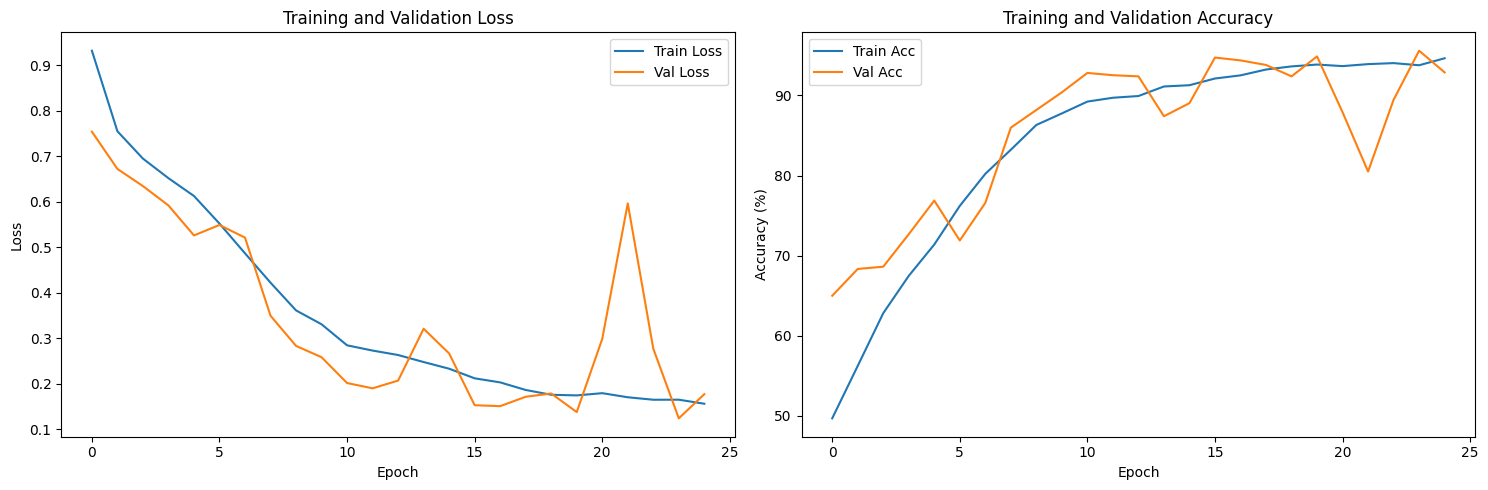

In [13]:
# Plot training history with learning rate
plt.figure(figsize=(15, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()


plt.tight_layout()
plt.show()

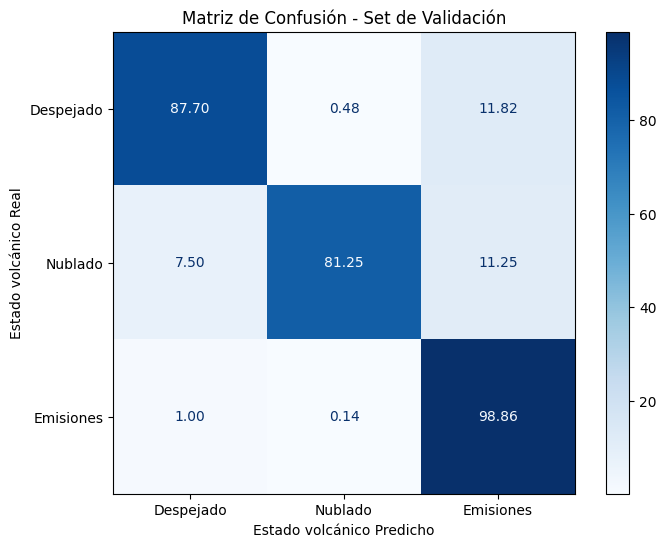

In [19]:
# Define label mapping
label_mapping = {
    'Despejado': 0,  # Clear
    'Nublado': 1,    # Cloudy
    'Emisiones': 2   # Emissions
}
class_names = list(label_mapping.keys())

# Get predictions and true labels for the validation set
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        corrected = batch['corrected'].float().to(device)
        edge = batch['edge'].float().to(device)
        thresholds = batch['thresholds'].float().to(device)
        labels = batch['label'].to(device)

        outputs = model(corrected, edge, thresholds)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Normalize confusion matrix by row (true labels) to get percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix with percentages
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=class_names)
disp.plot(cmap='Blues', values_format=".2f", ax=ax)
plt.title("Matriz de Confusión - Set de Validación")
plt.xlabel("Estado volcánico Predicho")
plt.ylabel("Estado volcánico Real")
plt.show()